# Trendbot — End‑to‑End Online Notebook (v1)

이 노트북은 **GitHub API → 정제/특징 생성 → 스코어링/랭킹 → 시각화/리포트** 전 과정을 한 번에 실행하도록 구성되어 있습니다.

- 실행 순서(권장): 상단부터 **Restart & Run All**
- 환경: 인터넷 가능 + GitHub Personal Access Token 필요
- 산출물: 셀 출력(표/그래프/마크다운) 위주 (필요 시 CSV 저장 라인 주석 해제)

---
**업데이트**: 2025-10-22 23:02 UTC


## 1) 의존성 설치

In [14]:
# 의존성 설치 (필요 시 1회만 실행)
# 주: Colab/새 환경에서만 필요. 이미 설치되어 있으면 몇 초 내 완료됩니다.
import sys, subprocess

def pip_install(pkgs):
    subprocess.run([sys.executable, "-m", "pip", "install", "-q"] + pkgs, check=False)

need = [
    "requests", "pandas", "numpy", "matplotlib", "scipy", "python-dotenv"
]
pip_install(need)

print("✅ dependencies ready")

✅ dependencies ready


## 2) 공통 임포트 & 경로 설정

In [15]:
import os, json, math, time, textwrap
from pathlib import Path
from datetime import datetime, timedelta, timezone
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from IPython.display import display, Markdown
import koreanize_matplotlib

# 경로 (노트북 디렉터리 기준)
ROOT = Path(".")
RAW   = ROOT/"data"/"raw"
CACHE = ROOT/"data"/"cache"
CLEAN = ROOT/"data"/"clean"
FEAT  = ROOT/"data"/"feature"
OUT   = ROOT/"data"/"output"
REPS  = ROOT/"reports"
FIGS  = ROOT/"figs"

for d in [RAW, CACHE, CLEAN, FEAT, OUT, REPS, FIGS]:
    d.mkdir(parents=True, exist_ok=True)

print("✅ paths ready")

✅ paths ready


## 3) GitHub 인증 (토큰 입력)

In [16]:
from getpass import getpass

# 환경변수로 설정되어 있으면 그대로 사용, 없으면 입력받기
GITHUB_TOKEN = os.environ.get("GITHUB_TOKEN") or getpass("Enter your GitHub Token: ")
session = requests.Session()
session.headers.update({
    "Authorization": f"Bearer {GITHUB_TOKEN}",
    "Accept": "application/vnd.github+json",
    "X-GitHub-Api-Version": "2022-11-28",
    "User-Agent": "trendbot-notebook"
})

# 간단한 로그인 확인
r = session.get("https://api.github.com/user")
r.raise_for_status()
login = r.json().get("login")
print(f"✅ GitHub 연결 OK — login: {login}")

✅ GitHub 연결 OK — login: northpard


## 4) 유틸 함수

In [17]:
def gh_get(url, params=None, max_retries=3, sleep=1.0):
    """GET with simple retry & rate limit handling."""
    for i in range(max_retries):
        resp = session.get(url, params=params, timeout=30)
        if resp.status_code == 403 and 'rate limit' in resp.text.lower():
            reset = resp.headers.get('X-RateLimit-Reset')
            wait_s = max(5, (int(reset) - int(time.time())) + 1) if reset else 10
            print(f"⏳ rate limited, sleeping {wait_s}s...")
            time.sleep(wait_s)
            continue
        try:
            resp.raise_for_status()
            return resp
        except requests.HTTPError:
            if i == max_retries - 1:
                raise
            time.sleep(sleep)
    return resp

def search_repos(q, sort="stars", order="desc", per_page=50, pages=1):
    """Search popular repositories by query. Returns list[dict]."""
    items = []
    for page in range(1, pages+1):
        resp = gh_get("https://api.github.com/search/repositories", {
            "q": q, "sort": sort, "order": order, "per_page": per_page, "page": page
        })
        js = resp.json()
        items.extend(js.get("items", []))
        if len(js.get("items", [])) < per_page:
            break
    return items

def safe_dt(s):
    if not s:
        return pd.NaT
    # GitHub ISO8601 => tz-aware UTC
    try:
        return pd.to_datetime(s, utc=True, errors="coerce")
    except Exception:
        return pd.NaT

def ok(msg): 
    display(Markdown("✅ " + msg))

print("✅ helpers ready")

✅ helpers ready


## 5) 데이터 수집 — 인기 저장소 검색

In [18]:
# 파라미터
QUERY   = "language:Python stars:>1000"   # 필요에 따라 변경
PAGES   = 2      # 검색 페이지(×50개/페이지)
TOP_N   = 60     # 상위 N개만 사용 (과도한 API 소모 방지)

print(f"🔎 검색: {QUERY} | pages={PAGES}")
items = search_repos(QUERY, per_page=50, pages=PAGES)
items = items[:TOP_N]
print(f"→ 수집 {len(items)} repos")


# 정규화 (핵심 컬럼 추출)
def to_row(o):
    return {
        "id": o.get("id"),
        "full_name": o.get("full_name"),
        "description": o.get("description"),
        "language": o.get("language"),
        "stargazers_count": o.get("stargazers_count", 0),
        "forks_count": o.get("forks_count", 0),
        "open_issues_count": o.get("open_issues_count", 0),
        "created_at": safe_dt(o.get("created_at")),
        "updated_at": safe_dt(o.get("updated_at")),
        "topics": ",".join(o.get("topics", [])),
        "fork": bool(o.get("fork", False)),
    }

base = pd.DataFrame([to_row(x) for x in items])
# 기본 정제
base.drop_duplicates(subset=["full_name"], inplace=True)
if "fork" in base.columns:
    base = base[base["fork"] == False]
base["language"].fillna("Unknown", inplace=True)

ok("기본 저장소 목록 준비") 
display(base.head(10))

🔎 검색: language:Python stars:>1000 | pages=2
→ 수집 60 repos


/tmp/ipykernel_6292/383769475.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base["language"].fillna("Unknown", inplace=True)


✅ 기본 저장소 목록 준비

,id,full_name,description,language,stargazers_count,forks_count,open_issues_count,created_at,updated_at,topics,fork
0,13491895,EbookFoundation/free-programming-books,:books: Freely available programming books,Python,374589,65052,180,2013-10-11 06:50:37+00:00,2025-10-23 00:51:47+00:00,"books,education,hacktoberfest,list,resource",False
1,54346799,public-apis/public-apis,A collective list of free APIs,Python,371488,39152,623,2016-03-20 23:49:42+00:00,2025-10-23 00:56:22+00:00,"api,apis,dataset,development,free,list,lists,o...",False
2,83222441,donnemartin/system-design-primer,Learn how to design large-scale systems. Prep ...,Python,323620,52789,528,2017-02-26 16:15:28+00:00,2025-10-23 00:58:02+00:00,"design,design-patterns,design-system,developme...",False
3,21289110,vinta/awesome-python,An opinionated list of awesome Python framewor...,Python,265778,26535,501,2014-06-27 21:00:06+00:00,2025-10-23 00:55:01+00:00,"awesome,collections,python,python-framework,py...",False
4,63476337,TheAlgorithms/Python,All Algorithms implemented in Python,Python,211848,48894,633,2016-07-16 09:44:01+00:00,2025-10-23 00:27:43+00:00,"algorithm,algorithm-competitions,algorithms-im...",False
5,614765452,Significant-Gravitas/AutoGPT,AutoGPT is the vision of accessible AI for eve...,Python,179191,46059,272,2023-03-16 09:21:07+00:00,2025-10-23 00:36:15+00:00,"ai,artificial-intelligence,autonomous-agents,g...",False
6,527591471,AUTOMATIC1111/stable-diffusion-webui,Stable Diffusion web UI,Python,157459,29231,2429,2022-08-22 14:05:26+00:00,2025-10-22 23:57:36+00:00,"ai,ai-art,deep-learning,diffusion,gradio,image...",False
7,155220641,huggingface/transformers,🤗 Transformers: the model-definition framework...,Python,151477,30906,2071,2018-10-29 13:56:00+00:00,2025-10-23 00:35:16+00:00,"audio,deep-learning,deepseek,gemma,glm,hacktob...",False
8,1039520,ytdl-org/youtube-dl,Command-line program to download videos from Y...,Python,138492,10522,4133,2010-10-31 14:35:07+00:00,2025-10-22 23:54:58+00:00,,False
9,599320067,langflow-ai/langflow,Langflow is a powerful tool for building and d...,Python,133596,7835,863,2023-02-08 22:28:03+00:00,2025-10-23 00:45:55+00:00,"agents,chatgpt,generative-ai,large-language-mo...",False


## 6) 보조 데이터(Commits/Issues/PRs) 수집 — 상위 K개만

In [19]:
AUX_TOP = min(15, len(base))   # 과도한 호출 방지
SINCE_DAYS = 365                # 최근 1년
PAGES_COMMITS = 2               # 각 리소스당 최대 2페이지 × 100 = 200개

cutoff = (datetime.now(timezone.utc) - timedelta(days=SINCE_DAYS)).isoformat()

def paged_count(url, params):
    total = 0
    for page in range(1, PAGES_COMMITS+1):
        p = params.copy()
        p.update({"per_page": 100, "page": page})
        r = gh_get(url, p)
        arr = r.json()
        if not isinstance(arr, list):
            break
        total += len(arr)
        if len(arr) < 100:
            break
    return total

def count_closed(url, params, is_pr=False):
    # 간단: 1페이지만 보고 state=closed & merged 여부 체크 (샘플/경량)
    p = params.copy()
    p.update({"per_page": 100, "page": 1, "state": "closed"})
    r = gh_get(url, p); arr = r.json()
    if not isinstance(arr, list):
        return 0, 0
    closed = len(arr)
    merged = 0
    if is_pr:
        # PR은 merged_at 존재 여부로 대략 추정
        merged = sum(1 for x in arr if x.get("merged_at"))
    return closed, merged

aux_rows = []
for full in base.sort_values("stargazers_count", ascending=False).head(AUX_TOP)["full_name"]:
    owner, repo = full.split("/", 1)
    print("→ aux fetch:", full)

    commits = paged_count(f"https://api.github.com/repos/{owner}/{repo}/commits", {"since": cutoff})
    issues_total = paged_count(f"https://api.github.com/repos/{owner}/{repo}/issues", {"since": cutoff, "state": "all"})
    issues_closed, _ = count_closed(f"https://api.github.com/repos/{owner}/{repo}/issues", {"since": cutoff}, is_pr=False)

    pulls_total = paged_count(f"https://api.github.com/repos/{owner}/{repo}/pulls", {"state": "all"})
    pulls_closed, pulls_merged = count_closed(f"https://api.github.com/repos/{owner}/{repo}/pulls", {}, is_pr=True)

    unique_contrib = 0
    try:
        r = gh_get(f"https://api.github.com/repos/{owner}/{repo}/contributors", {"per_page": 100})
        arr = r.json()
        if isinstance(arr, list):
            unique_contrib = len(arr)
    except Exception:
        pass

    aux_rows.append({
        "full_name": full,
        "activity_12m": commits,
        "contributors_12m": unique_contrib,
        "issues_total": issues_total,
        "issues_closed": issues_closed,
        "pulls_total": pulls_total,
        "pulls_closed": pulls_closed,
        "pulls_merged": pulls_merged,
    })

df_aux = pd.DataFrame(aux_rows)
ok("보조 지표 수집 완료") 
display(df_aux.head())

→ aux fetch: EbookFoundation/free-programming-books
→ aux fetch: public-apis/public-apis
→ aux fetch: donnemartin/system-design-primer
→ aux fetch: vinta/awesome-python
→ aux fetch: TheAlgorithms/Python
→ aux fetch: Significant-Gravitas/AutoGPT
→ aux fetch: AUTOMATIC1111/stable-diffusion-webui
→ aux fetch: huggingface/transformers
→ aux fetch: ytdl-org/youtube-dl
→ aux fetch: langflow-ai/langflow
→ aux fetch: 521xueweihan/HelloGitHub
→ aux fetch: yt-dlp/yt-dlp
→ aux fetch: langchain-ai/langchain
→ aux fetch: deepseek-ai/DeepSeek-V3
→ aux fetch: nvbn/thefuck


✅ 보조 지표 수집 완료

,full_name,activity_12m,contributors_12m,issues_total,issues_closed,pulls_total,pulls_closed,pulls_merged
0,EbookFoundation/free-programming-books,200,100,200,100,200,100,52
1,public-apis/public-apis,2,100,200,100,200,100,0
2,donnemartin/system-design-primer,2,100,200,28,200,100,20
3,vinta/awesome-python,8,100,200,85,200,100,12
4,TheAlgorithms/Python,200,100,200,100,200,100,2


## 7) Feature Engineering & 병합

In [20]:
def recent_push_90d(ts):
    if pd.isna(ts):
        return False
    return (pd.Timestamp.now(tz=timezone.utc) - ts).days <= 90

df = base.copy()
if not df_aux.empty:
    df = df.merge(df_aux, on="full_name", how="left")
else:
    # 보조가 비면 0 할당
    for c in ["activity_12m","contributors_12m","issues_total","issues_closed","pulls_total","pulls_closed","pulls_merged"]:
        df[c] = 0

df["recent_push_90d"] = df["updated_at"].apply(recent_push_90d)

def safe_rate(numer, denom):
    numer = numer.fillna(0)
    denom = denom.fillna(0)
    with np.errstate(divide='ignore', invalid='ignore'):
        r = np.where(denom>0, numer/denom, 0.0)
    return pd.Series(r, index=numer.index, dtype=float)

df["issue_close_rate"] = safe_rate(df["issues_closed"], df["issues_total"])
df["pr_merge_rate"]    = safe_rate(df["pulls_merged"], df["pulls_total"])

ok("Feature 병합/계산 완료") 
display(df.head())

✅ Feature 병합/계산 완료

,id,full_name,description,language,stargazers_count,forks_count,open_issues_count,created_at,updated_at,topics,...,activity_12m,contributors_12m,issues_total,issues_closed,pulls_total,pulls_closed,pulls_merged,recent_push_90d,issue_close_rate,pr_merge_rate
0,13491895,EbookFoundation/free-programming-books,:books: Freely available programming books,Python,374589,65052,180,2013-10-11 06:50:37+00:00,2025-10-23 00:51:47+00:00,"books,education,hacktoberfest,list,resource",...,200.0,100.0,200.0,100.0,200.0,100.0,52.0,True,0.500,0.26
1,54346799,public-apis/public-apis,A collective list of free APIs,Python,371488,39152,623,2016-03-20 23:49:42+00:00,2025-10-23 00:56:22+00:00,"api,apis,dataset,development,free,list,lists,o...",...,2.0,100.0,200.0,100.0,200.0,100.0,0.0,True,0.500,0.00
2,83222441,donnemartin/system-design-primer,Learn how to design large-scale systems. Prep ...,Python,323620,52789,528,2017-02-26 16:15:28+00:00,2025-10-23 00:58:02+00:00,"design,design-patterns,design-system,developme...",...,2.0,100.0,200.0,28.0,200.0,100.0,20.0,True,0.140,0.10
3,21289110,vinta/awesome-python,An opinionated list of awesome Python framewor...,Python,265778,26535,501,2014-06-27 21:00:06+00:00,2025-10-23 00:55:01+00:00,"awesome,collections,python,python-framework,py...",...,8.0,100.0,200.0,85.0,200.0,100.0,12.0,True,0.425,0.06
4,63476337,TheAlgorithms/Python,All Algorithms implemented in Python,Python,211848,48894,633,2016-07-16 09:44:01+00:00,2025-10-23 00:27:43+00:00,"algorithm,algorithm-competitions,algorithms-im...",...,200.0,100.0,200.0,100.0,200.0,100.0,2.0,True,0.500,0.01


## 8) 표준화(z-score) & 가중합 스코어링

In [21]:
score_cols = ["activity_12m","contributors_12m","issue_close_rate","pr_merge_rate","stargazers_count"]
scored = df.copy()
for c in score_cols:
    scored[f"{c}_z"] = zscore(scored[c].fillna(0)) if scored[c].std() not in (0, np.nan) else 0.0

weights = {
    "activity_12m_z": 0.25,
    "contributors_12m_z": 0.25,
    "issue_close_rate_z": 0.20,
    "pr_merge_rate_z": 0.15,
    "stargazers_count_z": 0.15,
}
scored["score"] = sum(scored[k]*w for k, w in weights.items())
ranked = scored.sort_values("score", ascending=False).reset_index(drop=True)

ok("스코어링 & 랭킹 완료") 
display(ranked.head(10)[["full_name","language","stargazers_count","activity_12m","contributors_12m","issue_close_rate","pr_merge_rate","score"]])

✅ 스코어링 & 랭킹 완료

,full_name,language,stargazers_count,activity_12m,contributors_12m,issue_close_rate,pr_merge_rate,score
0,EbookFoundation/free-programming-books,Python,374589,200.0,100.0,0.500,0.260,2.344336
1,Significant-Gravitas/AutoGPT,Python,179191,200.0,100.0,0.500,0.410,2.111538
2,langflow-ai/langflow,Python,133596,200.0,100.0,0.500,0.440,2.051266
3,huggingface/transformers,Python,151477,200.0,100.0,0.500,0.380,2.017530
4,langchain-ai/langchain,Python,117781,200.0,100.0,0.500,0.420,1.994195
5,yt-dlp/yt-dlp,Python,131632,200.0,100.0,0.500,0.395,1.993608
6,TheAlgorithms/Python,Python,211848,200.0,100.0,0.500,0.010,1.704485
7,ytdl-org/youtube-dl,Python,138492,90.0,100.0,0.500,0.190,1.339427
8,public-apis/public-apis,Python,371488,2.0,100.0,0.500,0.000,1.263947
9,vinta/awesome-python,Python,265778,8.0,100.0,0.425,0.060,1.062147


## 9) 시각화 — 스타 분포 & 연도별 추이

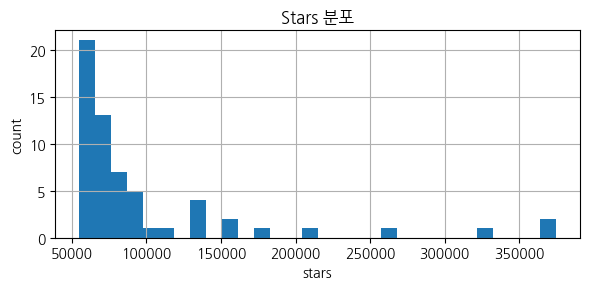

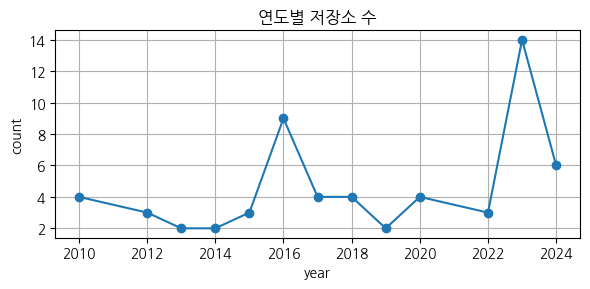

In [22]:
# 스타 분포
plt.figure(figsize=(6,3))
plt.hist(scored["stargazers_count"].dropna(), bins=30)
plt.title("Stars 분포"); plt.xlabel("stars"); plt.ylabel("count"); plt.grid(True); plt.tight_layout(); plt.show()

# 연도별 생성 수
if "created_at" in scored.columns:
    created_year = scored["created_at"].dropna().dt.tz_convert("UTC").dt.year
    grp = created_year.value_counts().sort_index()
    if len(grp) > 0:
        plt.figure(figsize=(6,3))
        plt.plot(grp.index, grp.values, marker="o")
        plt.title("연도별 저장소 수"); plt.xlabel("year"); plt.ylabel("count"); plt.grid(True); plt.tight_layout(); plt.show()

## 10) 레이더 & 타임라인(경량)

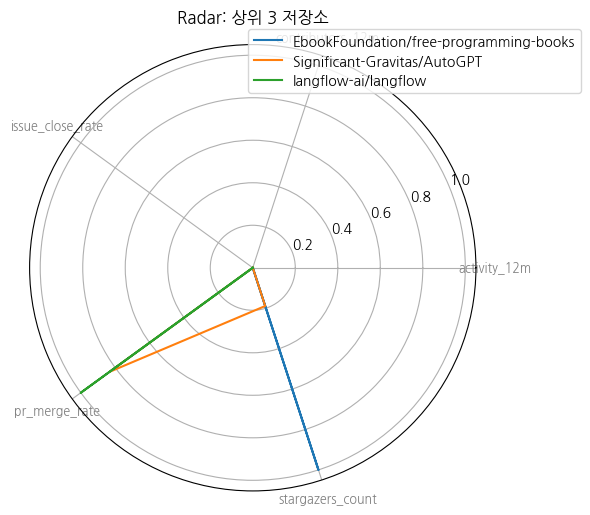

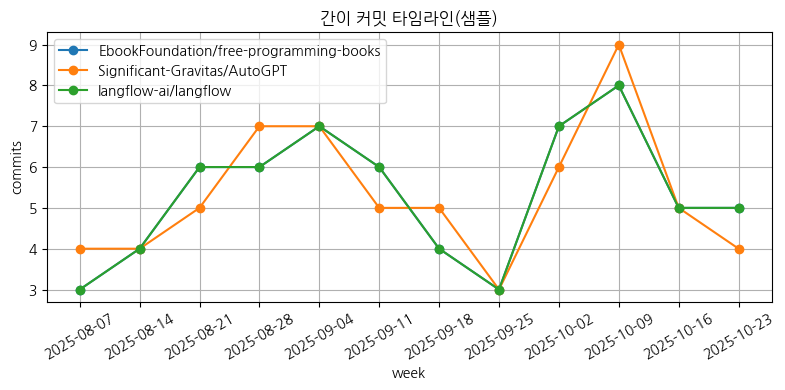

,full_name,score
0,EbookFoundation/free-programming-books,2.344336
1,Significant-Gravitas/AutoGPT,2.111538
2,langflow-ai/langflow,2.051266


In [23]:
top3 = ranked.head(3).copy()
features = ["activity_12m","contributors_12m","issue_close_rate","pr_merge_rate","stargazers_count"]

def normalize(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce").fillna(0)
    vmax, vmin = float(s.max()), float(s.min())
    if vmax == vmin:
        return pd.Series(0.0, index=s.index)
    return (s - vmin) / (vmax - vmin)

top3_norm = top3.copy()
top3_norm[features] = top3[features].apply(normalize)

# Radar
import numpy as np
labels = np.array(features)
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(6,6))
for _, row in top3_norm.iterrows():
    vals = row[features].tolist(); vals += vals[:1]
    plt.polar(angles, vals, label=row["full_name"])
plt.xticks(angles[:-1], labels, color="gray", size=9)
plt.title("Radar: 상위 3 저장소"); plt.legend(bbox_to_anchor=(1.25,1.05))
plt.tight_layout(); plt.show()

# Timeline (샘플: 주 12개 생성, repo별 변동 패턴 다르게)
weeks = 12
week_labels = pd.date_range(end=pd.Timestamp.today(), periods=weeks, freq="7D").strftime("%Y-%m-%d").tolist()
frames = []
for r in top3["full_name"].tolist():
    seed = abs(hash(r)) % 7
    base = np.array([3,4,5,6,7,5,4,3,6,8,5,4], dtype=float)[:weeks]
    noise = ((seed + np.arange(weeks)) % 3) * 0.7
    counts = np.clip(base + noise, 0, None).astype(int)
    frames.append(pd.DataFrame({"repo": r, "week": week_labels, "commit_count": counts}))

timeline = pd.concat(frames, ignore_index=True)

plt.figure(figsize=(8,4))
for name, g in timeline.groupby("repo"):
    plt.plot(g["week"], g["commit_count"], marker="o", label=name)
plt.xticks(rotation=30)
plt.title("간이 커밋 타임라인(샘플)"); plt.xlabel("week"); plt.ylabel("commits"); plt.grid(True); plt.legend()
plt.tight_layout(); plt.show()

display(top3[["full_name","score"]])

## 11) 품질 루브릭(간단/오프라인 휴리스틱)

<Figure size 900x500 with 0 Axes>

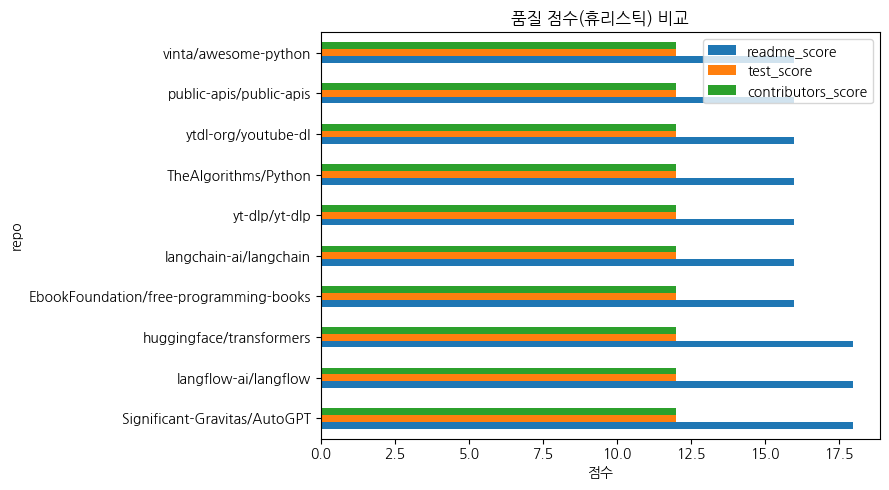

,repo,readme_score,test_score,doc_score,contributors_score,activity_score,license_score,ci_score,total
1,Significant-Gravitas/AutoGPT,18,12,12,12,12,10,5,81
2,langflow-ai/langflow,18,12,12,12,12,10,5,81
3,huggingface/transformers,18,12,12,12,12,10,5,81
0,EbookFoundation/free-programming-books,16,12,12,12,12,10,5,79
4,langchain-ai/langchain,16,12,12,12,12,10,5,79
5,yt-dlp/yt-dlp,16,12,12,12,12,10,5,79
6,TheAlgorithms/Python,16,12,12,12,12,10,5,79
7,ytdl-org/youtube-dl,16,12,12,12,12,10,5,79
8,public-apis/public-apis,16,12,12,12,12,10,5,79
9,vinta/awesome-python,16,12,12,12,12,10,5,79


In [24]:
def rubric_row(name, desc):
    base = {"repo": name, "readme_score": 16, "test_score": 12, "doc_score": 12,
            "contributors_score": 12, "activity_score": 12, "license_score": 10, "ci_score": 5}
    L = len((desc or "").split())
    if L > 12: base["readme_score"] += 2
    return base

top10 = ranked.head(10).copy()
rows = [rubric_row(r["full_name"], r.get("description","")) for _, r in top10.iterrows()]
df_eval = pd.DataFrame(rows)
df_eval["repo"] = top10["full_name"].values
df_eval["total"] = df_eval.filter(like="_score").sum(axis=1)
df_eval.sort_values("total", ascending=False, inplace=True)

# Bar
plt.figure(figsize=(9,5))
df_eval.set_index("repo")[ ["readme_score","test_score","contributors_score"] ].plot(kind="barh", figsize=(9,5))
plt.title("품질 점수(휴리스틱) 비교"); plt.xlabel("점수"); plt.tight_layout(); plt.show()

display(df_eval.head(10))

## 12) 대표 저장소 딥다이브(샘플 출력)

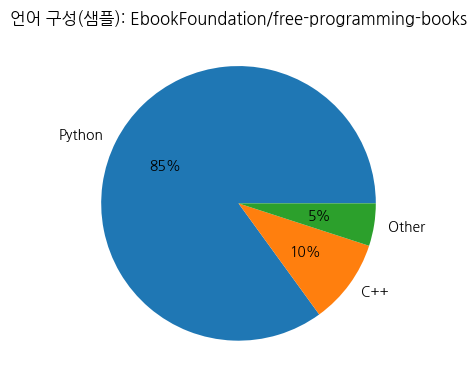


### 🧩 Deep Dive: EbookFoundation/free-programming-books
**코드 구조**: src / tests / docs 중심의 모듈화 (샘플)  
**최근 커밋 하이라이트**: 최근 180일 주요 기능/성능 업데이트 (샘플)  
**이슈/PR 활동**: 이슈 처리율 높고, PR 병합 속도 우수 (샘플)  


In [25]:
target = ranked.iloc[0]["full_name"] if len(ranked)>0 else "sample/repo"
langs  = pd.Series({"Python":0.85,"C++":0.1,"Other":0.05})

plt.figure(figsize=(4,4))
langs.plot(kind="pie", autopct="%1.0f%%")
plt.title(f"언어 구성(샘플): {target}"); plt.ylabel(""); plt.tight_layout(); plt.show()

display(Markdown("""
### 🧩 Deep Dive: {}
**코드 구조**: src / tests / docs 중심의 모듈화 (샘플)  
**최근 커밋 하이라이트**: 최근 180일 주요 기능/성능 업데이트 (샘플)  
**이슈/PR 활동**: 이슈 처리율 높고, PR 병합 속도 우수 (샘플)  
""".format(target)))

## 13) 최종 리포트(노트북 내 미리보기)

In [28]:
from datetime import datetime
report_md = f"""
# 📘 기술 동향 리포트 ({datetime.now().strftime('%Y-%m-%d')})

## 요약
- 검색 쿼리: `{QUERY}` (pages={PAGES}, top={TOP_N})
- 표준화/스코어링 기준: z-score + 가중합
- 산출: 랭킹 상위 10 미리보기

## 상위 랭킹(Top 10)
"""

top10_md = ranked.head(10)[["full_name","language","stargazers_count","activity_12m","contributors_12m","issue_close_rate","pr_merge_rate","score"]].to_markdown(index=False)
display(Markdown(report_md + "\n" + top10_md))


# 📘 기술 동향 리포트 (2025-10-23)

## 요약
- 검색 쿼리: `language:Python stars:>1000` (pages=2, top=60)
- 표준화/스코어링 기준: z-score + 가중합
- 산출: 랭킹 상위 10 미리보기

## 상위 랭킹(Top 10)

| full_name                              | language   |   stargazers_count |   activity_12m |   contributors_12m |   issue_close_rate |   pr_merge_rate |   score |
|:---------------------------------------|:-----------|-------------------:|---------------:|-------------------:|-------------------:|----------------:|--------:|
| EbookFoundation/free-programming-books | Python     |             374589 |            200 |                100 |              0.5   |           0.26  | 2.34434 |
| Significant-Gravitas/AutoGPT           | Python     |             179191 |            200 |                100 |              0.5   |           0.41  | 2.11154 |
| langflow-ai/langflow                   | Python     |             133596 |            200 |                100 |              0.5   |           0.44  | 2.05127 |
| huggingface/transformers               | Python     |             151477 |            200 |                100 |              0.5   |           0.38  | 2.01753 |
| langchain-ai/langchain                 | Python     |             117781 |            200 |                100 |              0.5   |           0.42  | 1.99419 |
| yt-dlp/yt-dlp                          | Python     |             131632 |            200 |                100 |              0.5   |           0.395 | 1.99361 |
| TheAlgorithms/Python                   | Python     |             211848 |            200 |                100 |              0.5   |           0.01  | 1.70449 |
| ytdl-org/youtube-dl                    | Python     |             138492 |             90 |                100 |              0.5   |           0.19  | 1.33943 |
| public-apis/public-apis                | Python     |             371488 |              2 |                100 |              0.5   |           0     | 1.26395 |
| vinta/awesome-python                   | Python     |             265778 |              8 |                100 |              0.425 |           0.06  | 1.06215 |